<a href="https://colab.research.google.com/github/nee1k/ab_testing/blob/main/Social_Media_A_B_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Problem Statement**

Facebook recently introduced a new bidding system called "average bidding" alongside the existing "maximum bidding" system. These bidding systems determine which ads get displayed to users based on how much advertisers are willing to pay.

With "maximum bidding," advertisers specify the maximum amount they are willing to pay for each impression. For example, an advertiser might say, "I'm willing to pay a maximum of $10 for each impression."

With "average bidding," advertisers specify an average amount. For instance, they might say, "On average, I'm willing to pay $6 for each impression."

**Is there a discernible and statistically significant difference between the two bidding options**?

Before diving into the analysis, we make the following **assumptions** regarding the product and its purpose:

#### **1. Purpose of the Bidding System**
- Facebook introduced **Average Bidding** to provide advertisers with **greater flexibility** in setting bids and to **potentially increase ad revenue**.
- The new system aims to **help small and mid-sized advertisers** compete more effectively with larger advertisers.
- The ultimate goal is to **optimize revenue per impression while maintaining advertiser satisfaction**.

#### **2. How the Bidding System Works**
- Both bidding types participate in the **same ad auction system**.
- **Maximum Bidders** always bid up to their set price, while **Average Bidders** bid dynamically to maintain their specified average.
- Advertisers can **switch between bidding systems**, but once selected, the system applies to all their campaigns.

#### **3. Advertiser Considerations**
- Advertisers may **select bidding strategies based on budget size, competition, and performance expectations**.
- Large advertisers with high budgets may **prefer Maximum Bidding for more control over impressions**.
- Smaller advertisers might **opt for Average Bidding to smooth out costs and remain competitive**.

#### **4. Auction Mechanism and Placement**
- Ads using **both bidding types** compete in the same **real-time ad auction**.
- Facebook’s ranking algorithm **still prioritizes ad quality and relevance** alongside bidding price.
- The effectiveness of each system **may vary by industry, geography, and campaign objectives**.

# **AARRR Metrics Framework for Facebook**

## **Introduction**
The AARRR framework (Acquisition, Activation, Retention, Referral, and Revenue) is a growth model that helps businesses track the user journey from first interaction to monetization. It provides clear insights into how users engage with a product and where optimizations are needed.

---

## **1. Acquisition (How do users find Facebook?)**
Acquisition refers to how users discover and sign up for Facebook.

### **Key Metrics:**
- **New User Signups** – Total number of users who create an account.
- **Signup Conversion Rate** – Percentage of visitors who complete the signup process.
- **Cost per Acquisition (CPA)** – Cost of acquiring a new user through ads or promotions.
- **Traffic Sources** – Breakdown of where new users come from (organic, paid ads, referrals).
- **App Store & Web Page Visits** – Number of users exploring Facebook before signing up.

### **How to Measure:**
- Track traffic sources using **Google Analytics, Meta Pixel, or internal logs**.
- Monitor signup funnel drop-off rates to optimize conversion steps.
- Analyze advertising campaigns' effectiveness and cost.

---

## **2. Activation (How quickly do users get value?)**
Activation measures whether users complete meaningful actions early in their journey.

### **Key Metrics:**
- **Profile Completion Rate** – Percentage of new users who add profile details.
- **Friend Connections within First Week** – Number of accepted friend requests in the first 7 days.
- **First Post or Interaction** – Number of users who post, like, or comment in their first session.
- **Time to First Engagement** – How quickly users perform their first social action.
- **Push Notification Opt-In Rate** – How many users allow notifications to stay engaged.

### **How to Measure:**
- Track **time-to-first-action** through event logs.
- Analyze **onboarding completion** rates and tweak flows to boost engagement.
- Monitor **friend suggestion acceptance rates** to improve connection-building.

---

## **3. Retention (How often do users return?)**
Retention tracks how frequently users return to Facebook over time.

### **Key Metrics:**
- **Daily Active Users (DAU) / Monthly Active Users (MAU)** – Number of users engaging daily/monthly.
- **Churn Rate** – Percentage of users who stop using Facebook after a certain period.
- **Stickiness Ratio (DAU/MAU)** – Measures how frequently users return.
- **Session Frequency & Length** – Number of times users open the app and how long they stay.
- **User Engagement Rate** – Likes, comments, shares, and messages per session.

### **How to Measure:**
- Monitor **cohort retention rates** to see how long users stay active.
- Analyze **push notification and email re-engagement effectiveness**.
- Use **heatmaps and session tracking** to understand drop-off points.

---

## **4. Referral (Do users invite others?)**
Referral measures whether existing users bring new users to Facebook.

### **Key Metrics:**
- **Referral Rate** – Percentage of users who invite others to join Facebook.
- **Virality Coefficient (K-Factor)** – How many additional users a new user invites.
- **Shares per User** – How often users share posts, pages, and invitations.
- **Messenger & WhatsApp Invites** – Number of users invited through Facebook messaging apps.
- **Community & Group Growth** – How many new users join Facebook via groups.

### **How to Measure:**
- Track **invites sent and accepted** from referral programs.
- Measure **click-through rates (CTR) on shared content** leading to signups.
- Conduct **A/B tests** on referral incentives to maximize invites.

---

## **5. Revenue (How does Facebook make money?)**
Revenue tracks how Facebook monetizes its user base.

### **Key Metrics:**
- **Ad Revenue per User (ARPU)** – Average revenue generated per user through ads.
- **Cost per Mille (CPM)** – Revenue earned per thousand ad impressions.
- **Click-Through Rate (CTR) on Ads** – Percentage of users clicking on ads.
- **Ad Impressions per User** – Number of ads displayed per user session.
- **Subscription Revenue (if applicable)** – Earnings from Facebook Blue or other premium features.

### **How to Measure:**
- Use **Facebook Ads Manager** to track ad spend, impressions, and conversions.
- Conduct **A/B tests on ad placements** to optimize revenue per session.
- Analyze **user behavior trends** to adjust monetization strategies without reducing engagement.

---

# **Defining Metrics for Facebook’s Bidding System Analysis**

## **North Star and Guardrail Metrics**

### **North Star Metric**  
- **Definition:** The **primary metric** that directly reflects the **success of the bidding system**.  
- **Chosen Metric: Revenue per Impression**  
  - **Why?** Since Facebook’s business model relies on ad revenue, the most important measure of success is how much revenue is generated **per ad impression**.
  - **Formula:** `Revenue per Impression = Total Revenue / Total Impressions`
  - **Insight:** This metric ensures we **maximize monetization efficiency** while maintaining advertiser value.

### **Guardrail Metrics**  
- **Definition:** **Supporting metrics** that ensure the bidding system is **not harming the overall ecosystem** (e.g., advertiser experience, user engagement, system fairness).  
- **Chosen Metrics:**  
  1. **Advertiser Retention Rate**:Ensures advertisers continue using the bidding system long-term.  
  2. **Ad Load & User Engagement**: Prevents excessive ad saturation that could **reduce user experience**.  
  3. **Click Quality (CTR vs. Conversion Rate)**: Ensures **high CTR is not driven by misleading or irrelevant ads**.

----

## **Success Metrics**

### **1. Impression-Based Metric**  
- **Metric: Impressions per Advertiser**  
  - **Why?** Determines how often advertisers' ads **are shown** under each bidding system.
  - **Formula:** `Total Impressions / Total Advertisers`
  - **Insight:** If **Average Bidding delivers significantly more impressions**, it may favor **higher ad exposure** at lower costs.

### **2. Engagement Metric**  
- **Metric: Click-Through Rate (CTR)**  
  - **Why?** Measures **user interaction** and ad relevance.
  - **Formula:** `CTR = Clicks / Impressions`
  - **Insight:** A **high CTR under Average Bidding** may indicate **more engaging ads**, but we must check conversion quality.

### **3. Conversion Metric**  
- **Metric: Conversion Rate**  
  - **Why?** Determines if **users take meaningful actions** after clicking.
  - **Formula:** `Conversion Rate = Purchases / Clicks`
  - **Insight:** If **CTR is high but conversion is low**, Average Bidding might be **delivering less valuable clicks**.


In [16]:
control_df = pd.read_csv("/content/drive/MyDrive/AB Testing/control_group.csv")
control_df

,Impression,Click,Purchase,Earning
0,82529,6090,665,2311
1,98050,3383,315,1743
2,82696,4168,458,1798
3,109914,4911,487,1696
4,108458,5988,441,1544
...,...,...,...,...
35,132064,3747,551,2257
36,86410,4608,345,1781
37,123679,3649,476,2188
38,101997,4736,475,2255


In [17]:
test_df = pd.read_csv("/content/drive/MyDrive/AB Testing/test_group.csv")
test_df

,Impression,Click,Purchase,Earning
0,120104,3217,702,1940
1,134776,3635,834,2929
2,107807,3057,423,2526
3,116445,4650,429,2281
4,145083,5201,750,2782
...,...,...,...,...
35,79235,6002,382,2278
36,130702,3626,450,2531
37,116482,4703,472,2598
38,79034,4495,425,2596


<ipython-input-21-e751acf6847d>:8: UserWarning:

Using Panel interactively in Colab notebooks requires the jupyter_bokeh package to be installed. Install it with:

    !pip install jupyter_bokeh

and try again.




pn.extension('tabulator')


pn.extension('tabulator')



Column
    [0] Select(options=['Impression', ...], value='Impression')
    [1] ParamFunction(function, _pane=Column, defer_load=False)
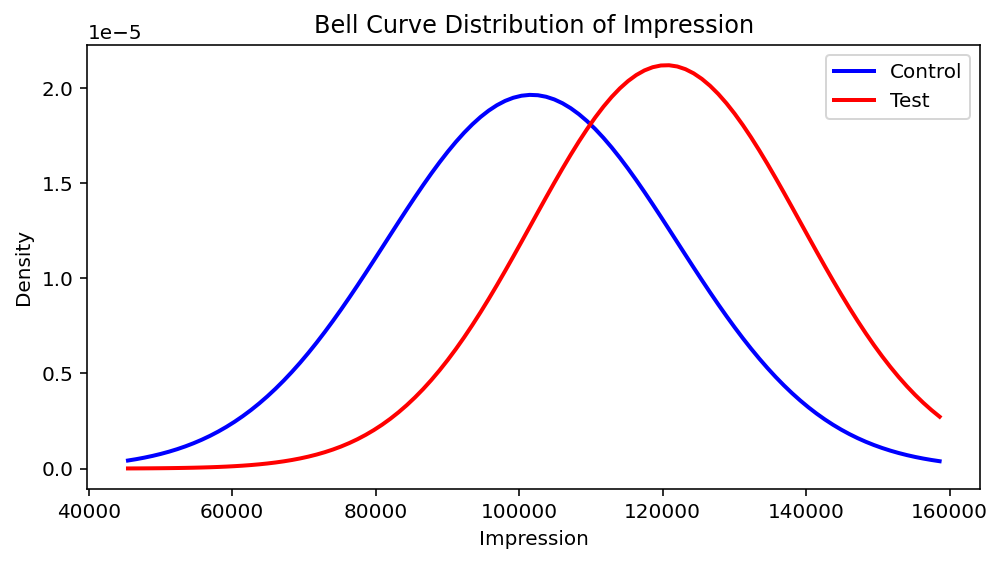

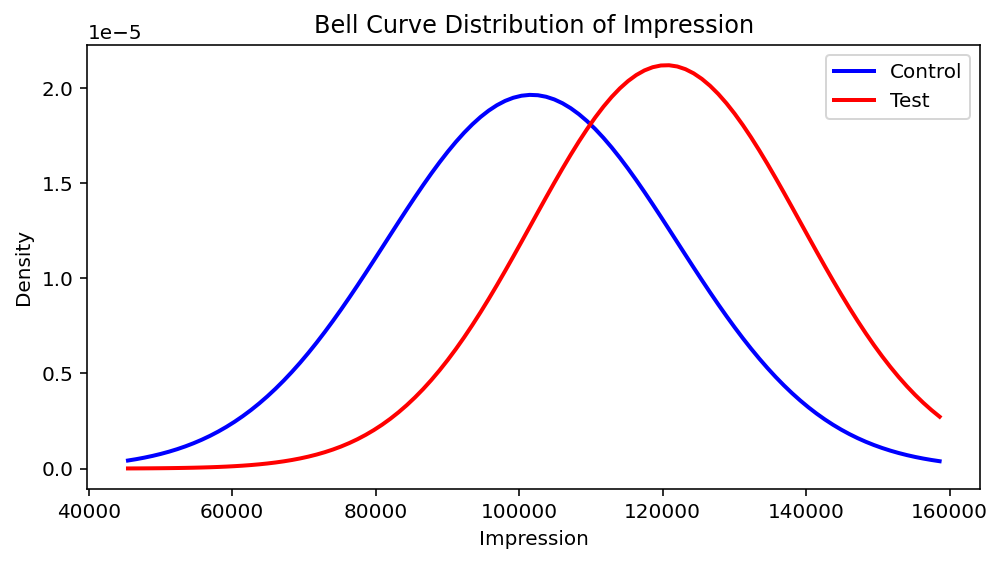

In [21]:
import panel as pn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm

# Enable Panel's extension
pn.extension()

# Assume control_df and test_df are predefined Pandas DataFrames with the columns:
# 'Impression', 'Click', 'Purchase', 'Earning'
# For example:
# control_df = pd.read_csv('control_data.csv')
# test_df = pd.read_csv('test_data.csv')

# Define the available metrics
metrics = ['Impression', 'Click', 'Purchase', 'Earning']
metric_select = pn.widgets.Select(name='Select Metric', options=metrics, value='Impression')

def update_plot(metric):
    """
    Generates a matplotlib figure displaying bell curves for the selected metric.
    Uses a normal distribution fit (mean and standard deviation) for both the control and test groups.
    """
    # Extract the relevant data from each group
    control_data = control_df[metric]
    test_data = test_df[metric]

    # Calculate the mean and standard deviation for each group
    control_mean, control_std = control_data.mean(), control_data.std()
    test_mean, test_std = test_data.mean(), test_data.std()

    # Define an x-range that covers the minimum and maximum values from both groups
    x_min = min(control_data.min(), test_data.min())
    x_max = max(control_data.max(), test_data.max())
    x_range = np.linspace(x_min, x_max, 100)

    # Compute the probability density functions for the control and test groups
    control_pdf = norm.pdf(x_range, control_mean, control_std)
    test_pdf = norm.pdf(x_range, test_mean, test_std)

    # Create the matplotlib figure
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(x_range, control_pdf, label='Control', color='blue', lw=2)
    ax.plot(x_range, test_pdf, label='Test', color='red', lw=2)
    ax.set_title(f'Bell Curve Distribution of {metric}')
    ax.set_xlabel(metric)
    ax.set_ylabel('Density')
    ax.legend()

    return fig

def get_descriptive_stats(df):
    """
    Computes descriptive statistics (mean, median, standard deviation) for each metric.
    Returns a DataFrame that can be displayed in a Tabulator widget.
    """
    stats = pd.DataFrame({
        'Mean': df.mean(),
        'Median': df.median(),
        'Std': df.std()
    })
    stats.index.name = 'Metric'
    stats.reset_index(inplace=True)
    return stats

@pn.depends(metric_select.param.value)
def dashboard(metric):
    """
    Updates the dashboard based on the selected metric.
    The dashboard includes:
      - A bell curve plot (using matplotlib) for the selected metric.
      - Two tables (using Panel's Tabulator) that show descriptive statistics for the control and test groups.
    """
    # Create the bell curve plot for the selected metric
    fig = update_plot(metric)

    # Compute descriptive statistics for both groups
    control_stats = get_descriptive_stats(control_df)
    test_stats = get_descriptive_stats(test_df)

    # Create the Tabulator widgets for the control and test groups
    control_tabulator = pn.widgets.Tabulator(control_stats,
                                             name='Control Group Descriptive Stats',
                                             width=400)
    test_tabulator = pn.widgets.Tabulator(test_stats,
                                          name='Test Group Descriptive Stats',
                                          width=400)

    # Combine the plot and the two tables into a single layout
    return pn.Column(
        pn.panel(fig, tight=True),
        pn.Row(control_tabulator, test_tabulator)
    )

# Create the overall layout with the metric selection widget and the dashboard components
dashboard_layout = pn.Column(metric_select, dashboard)

# To serve the dashboard in a Jupyter Notebook, display the layout:
dashboard_layout.servable()

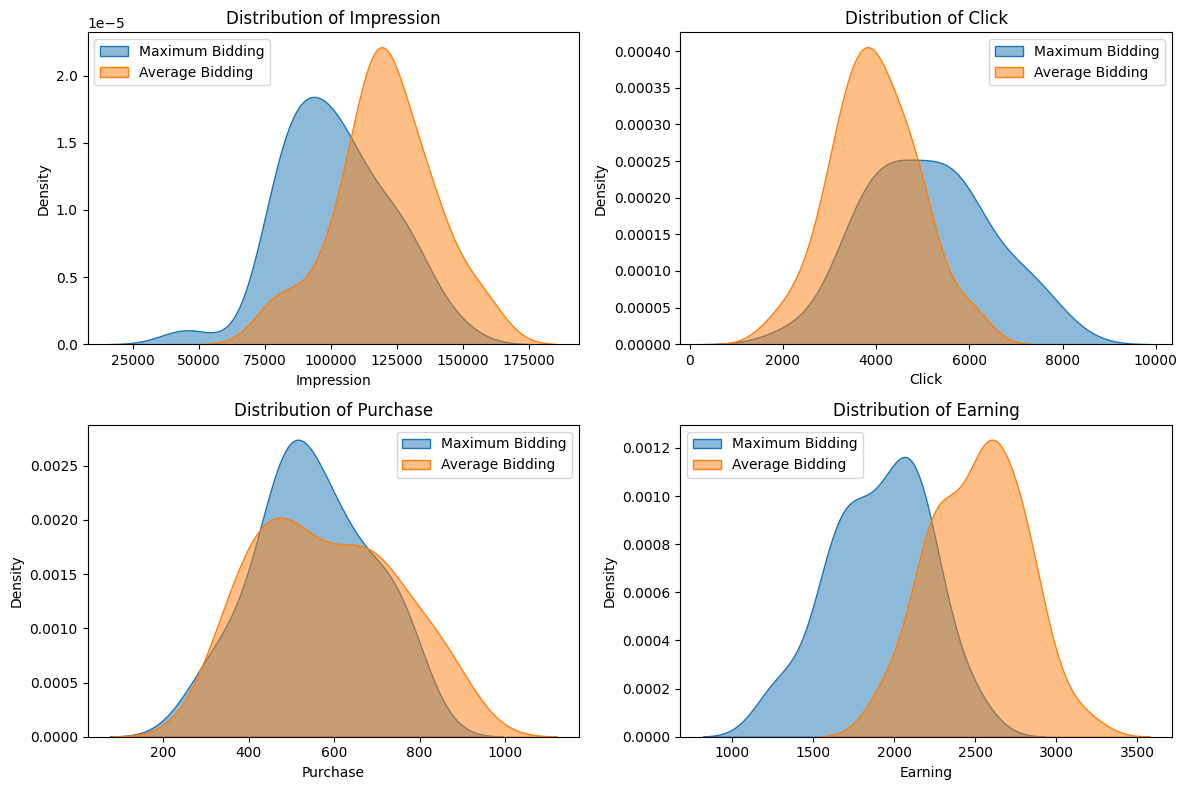

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axes for the subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Define the column names
columns = ['Impression', 'Click', 'Purchase', 'Earning']

# Loop through the columns and create distribution plots for each
for i, col in enumerate(columns):
    row = i // 2  # Determine the row index
    col_idx = i % 2  # Determine the column index

    # Plot the distribution for control group
    sns.kdeplot(control_df[col], ax=axes[row, col_idx], label='Maximum Bidding', fill=True, alpha=0.5)

    # Plot the distribution for test group
    sns.kdeplot(test_df[col], ax=axes[row, col_idx], label='Average Bidding', fill=True, alpha=0.5)  # Overlay the test data


    axes[row, col_idx].set_title(f'Distribution of {col}')
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('Density')
    axes[row, col_idx].legend()


# Adjust layout and display the plot
plt.tight_layout()
plt.show()




## **Hypothesis Testing**

### **Null and Alternate Hypotheses**
In hypothesis testing, the null hypothesis (H0) is a statement that assumes there is no significant effect, relationship, or difference between the variables being studied. The alternative hypothesis (H1 or Ha) is a statement that contradicts the null hypothesis, suggesting the presence of a significant effect, relationship, or difference.

* **Null Hypothesis (H0):** There is no significant difference in the effectiveness (e.g., clicks, purchases) between 'average bidding' and 'maximum bidding.'
* **Alternative Hypothesis (H1):** There is a significant difference in the effectiveness (e.g., clicks, purchases) between 'average bidding' and 'maximum bidding.'

### **Significance Level (Alpha)**
The significance level (alpha) is the probability of rejecting the null hypothesis when it is actually true (Type I error). It represents the risk we are willing to take of making a false positive conclusion.

Setting **Alpha (α)** as 0.05 (5%) - This means we are willing to accept a 5% chance of incorrectly concluding that there is a difference between the bidding strategies when there actually isn't.

### **Statistical Power (1 - Beta)**
Statistical power (1 - beta) is the probability of correctly rejecting the null hypothesis when it is false (i.e., detecting a true effect). It represents the likelihood of finding a statistically significant difference if one truly exists.

Setting **Power (1 - β)** as 0.80 (80%) - This means we want an 80% chance of detecting a significant difference between the bidding strategies if a meaningful difference truly exists.

### **Minimum Detectable Effect (MDE)**
The Minimum Detectable Effect (MDE) is the smallest effect size that we want to be able to detect with our hypothesis test. It represents the practical significance of the difference between the groups. Setting an MDE helps us to determine the required sample size to achieve the desired power.

Setting **MDE** as 500 - This means a $500 increase in earnings for the average bidding strategy compared to the maximum bidding strategy.


### **Sample Size**

Calculating the sample size is crucial for ensuring the experiment has enough statistical power to detect a meaningful difference between groups. It involves determining the number of observations needed to achieve the desired significance level, power, and MDE.

**Formula:**
n = 2 * (Zα/2 + Zβ)^2 * (σ^2) / (MDE)^2

where:
* `n` is the sample size per group.
* `Zα/2` is the critical value for the significance level.
* `Zβ` is the critical value for the desired power.
* `σ^2` is the pooled variance.
* `MDE` is the minimum detectable effect.sub

**Example:**
Assuming:
* Significance level (alpha): 0.05
* Power (1 - beta): 0.80

The sample size per group is approximated as:
n = (16 * (σ^2)) / (MDE)^2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

alpha = 0.05
beta = 0.2
mde = 0.01

Z = (norm.ppf(1-(alpha/2),
              loc=0,
              scale=1) +
     norm.ppf(1-beta,
              loc=0,
              scale=1))**2

var = 20

sample_size = (Z*2*var)/(mde**2)

print(sample_size.astype('int'))

3139551


## **Design and Run the Experiment**

In A/B testing, comparing **two independent means** often involves the application of a **independent samples t-test**. This statistical method assesses whether there is a significant difference between the means of two groups, typically a **control group (A)** and a **treatment group (B)**. The t-test assumes that the data in both groups are normally distributed, and it is particularly robust when sample sizes are relatively large. An important consideration in the independent samples t-test is the **assumption regarding the equality of variances** between the two groups. The test can be applied under the assumption of equal variances (homogeneity of variances) or unequal variances, and the choice between these options impacts the interpretation of the results. Therefore, when performing an independent-samples t-test in the context of A/B testing, researchers must carefully consider and, if needed, test the assumption of equality of variances to ensure the **validity** and **reliability** of their statistical analysis. For more details about two-independent-sample t-test see .[*here*.](https://www.kaggle.com/code/zahrazolghadr/independent-samples-t-test)

### **Data Collection**
- **Impression**: number of impressions per advertisement
- **Click**: number of clicks per advertisement
- **Purchase**: number of products purchased after a click
- **Earnings**: earnings after the purchase


<ipython-input-4-98e714d91058>:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


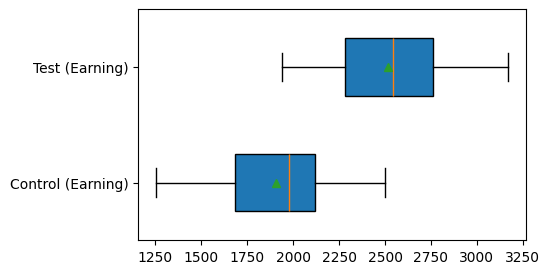

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))

ax.boxplot(
    x=[control_df['Earning'], test_df['Earning']],
    vert=False,
    patch_artist=True,
    widths=0.5,
    sym='r|',
    labels=['Control (Earning)','Test (Earning)'],
    showmeans=True,
    showfliers=True
)

plt.show()

In [5]:
import pandas as pd
from scipy.stats import levene
from scipy.stats import ttest_ind

mean_control = control_df['Earning'].mean()
mean_test = test_df['Earning'].mean()

print("mean_control=", mean_control)
print("mean_test=",mean_test)

# Perform two-sample t-test for each level of 'pathsize_cat'
groupC = control_df['Earning']
groupT = test_df['Earning']

# Perform Levene's test for homogeneity of variances
statistic, p_value_L = levene(groupC, groupT)

if  p_value_L > 0.05:

    t_statistic, p_value = ttest_ind(groupC, groupT,alternative="less" ,equal_var=True)

    print("t-statistic:", t_statistic)
    print("p-value:", p_value)

else:

    t_statistic, p_value = ttest_ind(groupC, groupT,alternative="less", equal_var=False)

    print("t-statistic:", t_statistic)
    print("p-value:", p_value)

# Determine significance
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means.")

mean_control= 1908.575
mean_test= 2514.925
t-statistic: -9.256092651165002
p-value: 1.720180077421263e-14
Reject the null hypothesis: There is a significant difference between the means.
